In [245]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix

In [246]:
seed = 2023

In [247]:
DATASETX = "./data/prep/HotelReservationsPreparedCleanX.csv"
DATASETY = "./data/prep/HotelReservationsY.csv"

In [248]:
df_x = pd.read_csv(DATASETX)
df_y = pd.read_csv(DATASETY)

In [249]:
df_x.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,0.0,-0.6,-1.000000,-0.882353,-1.0,1.0,-1.0,-0.990971,0.454545,-0.933333,0.0,-1.0,-1.0,-1.0,-0.044444,-0.6
1,0.0,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.823928,0.272727,-0.133333,-1.0,-1.0,-1.0,-1.0,-0.624074,-1.0
2,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.936795,1.000000,0.733333,0.0,-1.0,-1.0,-1.0,-0.603704,-1.0
3,0.0,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.548533,0.636364,0.000000,-1.0,-1.0,-1.0,-1.0,-0.600000,-1.0
4,-0.5,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.002257,0.272727,-0.266667,-1.0,-1.0,-1.0,-1.0,-0.729630,-1.0


In [250]:
df_y.head()

,booking_status
0,1
1,1
2,1
3,0
4,1


In [251]:
df = pd.concat([df_x, df_y], axis=1)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0.0,-0.6,-1.000000,-0.882353,-1.0,1.0,-1.0,-0.990971,0.454545,-0.933333,0.0,-1.0,-1.0,-1.0,-0.044444,-0.6,1
1,0.0,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.823928,0.272727,-0.133333,-1.0,-1.0,-1.0,-1.0,-0.624074,-1.0,1
2,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.936795,1.000000,0.733333,0.0,-1.0,-1.0,-1.0,-0.603704,-1.0,1
3,0.0,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.548533,0.636364,0.000000,-1.0,-1.0,-1.0,-1.0,-0.600000,-1.0,0
4,-0.5,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.002257,0.272727,-0.266667,-1.0,-1.0,-1.0,-1.0,-0.729630,-1.0,1


In [252]:
df = shuffle(df, random_state=seed)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
16377,-0.5,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.665914,0.454545,0.133333,-1.0,-1.0,-1.0,-1.0,-0.677778,-1.0,1
24639,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.674944,-0.454545,0.466667,0.0,-1.0,-1.0,-1.0,-0.647407,-0.6,1
21974,0.0,-1.0,-0.428571,-1.000000,-1.0,1.0,1.0,-0.268623,-0.090909,0.666667,0.0,-1.0,-1.0,-1.0,-0.576667,-0.6,0
9205,0.0,-0.8,-1.000000,-0.647059,-1.0,-1.0,0.0,-0.503386,-0.454545,0.733333,0.0,-1.0,-1.0,-1.0,-0.643333,-0.6,1
33303,0.0,-1.0,-0.428571,-0.411765,-1.0,-1.0,1.0,-0.399549,0.090909,0.000000,0.0,-1.0,-1.0,-1.0,-0.575444,-0.6,1


In [253]:
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1

In [254]:
train_set, temp_set = train_test_split(df, train_size=TRAIN_SIZE, random_state=seed)

validation_set, test_set = train_test_split(temp_set, train_size=VALIDATION_SIZE / (VALIDATION_SIZE + TEST_SIZE), random_state=seed)

In [255]:
X_train = train_set.drop('booking_status', axis=1)
y_train = train_set['booking_status']

X_val = validation_set.drop('booking_status', axis=1)
y_val = validation_set['booking_status']

X_test = test_set.drop('booking_status', axis=1)
y_test = test_set['booking_status']

In [256]:
INPUTS = X_train.shape[1]
OUTPUTS = 1
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (X_val.shape[0]/1))

In [257]:
n_epochs =1000
lr = 0.1
batch_size = 128
tasa_dropout = 0.25
error = 0.01
n_neurons_per_hlayer = [250, 600, 250, 125, 50, 10]

In [258]:
model = keras.Sequential(name="DeepFeedforward")

In [259]:
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons, kernel_initializer="he_normal", use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation("elu"))
  model.add(tf.keras.layers.Dropout(tasa_dropout))

model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "DeepFeedforward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 250)               4000      
                                                                 
 batch_normalization_66 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 activation_66 (Activation)  (None, 250)               0         
                                                                 
 dropout_66 (Dropout)        (None, 250)               0         
                                                                 
 dense_78 (Dense)            (None, 600)               150000    
                                                                 
 batch_normalization_67 (Ba  (None, 600)               2400      
 tchNormalization)                                 

In [260]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_binary_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_binary_accuracy', factor=0.1, patience=45, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping('val_binary_accuracy', patience=101, verbose=1)

callbacks = [model_checkpoint, early_stop]

In [261]:
from tensorflow.keras.optimizers import Adam, SGD

opt = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
#opt = SGD(learning_rate=0.1, momentum=0.9, nesterov=False)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=["binary_accuracy"]
)

In [262]:
import numpy as np

start = time.perf_counter()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, callbacks=callbacks, validation_data=(X_val, y_val))
print (time.perf_counter() - start)
best_idx = int(np.argmax(history.history['val_binary_accuracy']))
best_value = np.max(history.history['val_binary_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_binary_accuracy ' + str(best_value))

Epoch 1/1000


c:\Users\Chema\Desktop\MASTER\DeepLearning\DL\.venv\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


226/227 [============================>.] - ETA: 0s - loss: 0.4520 - binary_accuracy: 0.7883

c:\Users\Chema\Desktop\MASTER\DeepLearning\DL\.venv\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



Epoch 1: val_binary_accuracy improved from -inf to 0.81638, saving model to model.hdf5
227/227 [==============================] - 9s 19ms/step - loss: 0.4517 - binary_accuracy: 0.7884 - val_loss: 0.5742 - val_binary_accuracy: 0.8164
Epoch 2/1000
  5/227 [..............................] - ETA: 3s - loss: 0.4150 - binary_accuracy: 0.8078

c:\Users\Chema\Desktop\MASTER\DeepLearning\DL\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - ETA: 0s - loss: 0.4167 - binary_accuracy: 0.8087
Epoch 2: val_binary_accuracy improved from 0.81638 to 0.81693, saving model to model.hdf5
227/227 [==============================] - 4s 16ms/step - loss: 0.4167 - binary_accuracy: 0.8087 - val_loss: 0.4028 - val_binary_accuracy: 0.8169
Epoch 3/1000
224/227 [============================>.] - ETA: 0s - loss: 0.4101 - binary_accuracy: 0.8147
Epoch 3: val_binary_accuracy did not improve from 0.81693
227/227 [==============================] - 4s 16ms/step - loss: 0.4102 - binary_accuracy: 0.8147 - val_loss: 0.8062 - val_binary_accuracy: 0.7963
Epoch 4/1000
226/227 [============================>.] - ETA: 0s - loss: 0.4037 - binary_accuracy: 0.8208
Epoch 4: val_binary_accuracy improved from 0.81693 to 0.83264, saving model to model.hdf5
227/227 [==============================] - 4s 16ms/step - loss: 0.4038 - binary_accuracy: 0.8208 - val_loss: 0.4389 - val_binary_accuracy: 0.8326
Epoch 5/1000
227/227 [

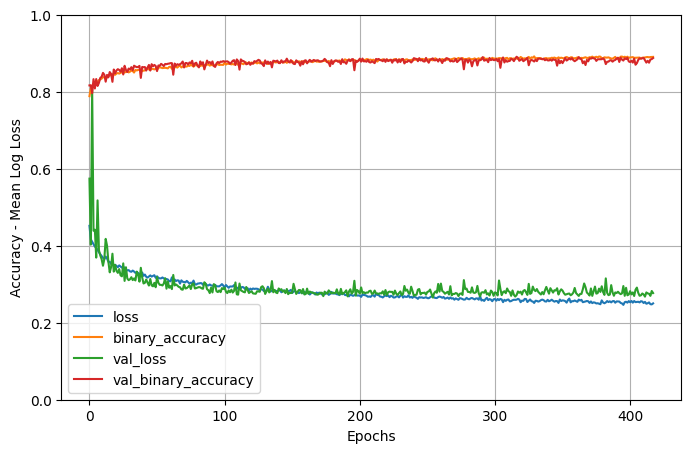

In [263]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig(f"./images/loss{n_neurons_per_hlayer}_{seed}_{n_epochs}.png")
plt.show()

In [264]:
print(f"Accuracy for the training set: {results.binary_accuracy.values[-1:][0]}")
print(
    f"Accuracy for the development test set: {best_value}"
)

Accuracy for the training set: 0.8904742002487183
Accuracy for the development test set: 0.8908188343048096


In [265]:
v = open("./history/DeepFeedforward.txt", "a")
v.write(f"Epoque: {n_epochs}\n")
v.write(f"Learning Rate: {lr}\n")
v.write(f"Batch Size: {batch_size}\n")
v.write(f"Dropout: {tasa_dropout}\n")
v.write(f"Neurons per layer: {n_neurons_per_hlayer}\n")
v.write(f"Activation: elu\n")
v.write(f"Optimizer: Adam\n")
v.write(f"seed = {seed}\n")
v.write(
    "model.add(keras.layers.Dense(neurons, kernel_initializer=he_normal, use_bias=False)); model.add(keras.layers.BatchNormalization()); model.add(keras.layers.Activation(elu)); model.add(tf.keras.layers.Dropout(tasa_dropout))"
)
v.write(
    "--------------------------------------------------------------------------------------------\n"
)
v.write(f"Accuracy for the training set: {results.binary_accuracy.values[-1:][0]}\n")
v.write(
    f"Accuracy for the development test set: {results.val_binary_accuracy.values[-1:][0]}\n"
)
v.write(f"Time: {time.perf_counter() - start}\n")
v.write(
    "--------------------------------------------------------------------------------------------\n"
)
v.close()

114/114 [==============================] - 1s 4ms/step


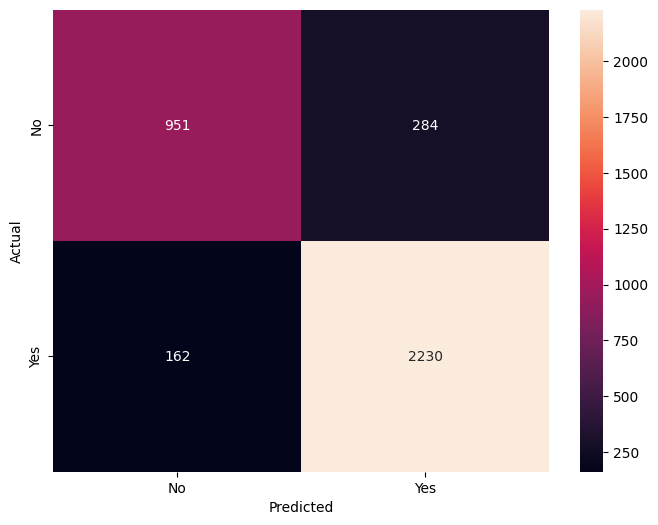

In [266]:
y_pred = model.predict(X_test).round()
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
